In [25]:
import numpy as np
from scipy.optimize import curve_fit
from utils import sample_observed_data_berkson, sample_observed_data_classical
from tqdm import tqdm

In [26]:
confidence_level = 0.90
num_realizations = 100
seed = 112
folder_path = '/dcs/pg23/u1604520/mem/results/exponential_berkson_unifstart/'
#folder_path = '/dcs/pg23/u1604520/mem/results/exponential_berkson_unifstart/misp/'
folder_path_mmd = '/dcs/pg23/u1604520/mem/results/exponential_berkson_unifstart/'

In [27]:
scales_nu = [0.000001, 0.5,  1.0, 2.0] 
num_scales = len(scales_nu)
c = 1
n = 200
B = 500
theta_star = np.array([1,3]) 
loc_x = 0
scale_x = 1
scale_eps = 0.5
num_methods = 2

In [28]:
def reg_func(theta,x):
    return (np.exp(theta[0] + theta[1]*x))/(1 + np.exp(theta[0] + theta[1]*x))

In [29]:
def nonlinear_model(x, a, b):
    return (np.exp(a + b*x))/(1 + np.exp(a + b*x)) 

In [30]:
mses = np.zeros((num_scales, num_realizations, num_methods, len(theta_star)))
stds = np.zeros((num_scales, num_realizations, num_methods, len(theta_star)))
counts = np.zeros((num_scales, len(theta_star)))
coverage_probabilities = np.zeros((num_scales, len(theta_star)))
for j, scale_nu in enumerate(scales_nu):
    seed1 = 12
    seed2 = 112
    seed = 12
    for r in range(num_realizations):
        seed2 += 1
        seed1 += 1
        seed += 1
        boot_sample = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed1{seed1}_seed2{seed2}.txt')
        data, x = sample_observed_data_berkson(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, seed1)
        mean_boot_sample = boot_sample.mean(axis=0)
        mmd_est = np.loadtxt(folder_path_mmd+f'mmd_est_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed1{seed1}_seed2{seed2}.txt')
        mses[j, r, 0, :] = np.asarray((mean_boot_sample - theta_star)**2)
        mses[j, r, 1, :] = np.asarray((mmd_est - theta_star)**2)

        # Credible interval 
        for i in range(len(theta_star)):
            count = 0
            lower_bound = np.percentile(boot_sample[:, i], (1 - confidence_level) / 2 * 100)
            upper_bound = np.percentile(boot_sample[:, i], (1 + confidence_level) / 2 * 100)
            if lower_bound <= theta_star[i] <= upper_bound:
                count += 1
            counts[j, i] += count
            
    # Calculate the coverage probability
    coverage_probabilities[j, :] = counts[j, :] / num_realizations
    mses_over_runs = np.mean(mses, axis=1)
    stds_mses_over_runs = np.std(mses, axis=1)
        
    print(f"Coverage Probability for theta_1 for ME std {scale_nu}: {coverage_probabilities[j, 0] * 100}%")
    print(f"Coverage Probability for theta_2 for ME std {scale_nu}: {coverage_probabilities[j, 1] * 100}%")
    print(f"Mean Squared error for Robust-MEM: {mses_over_runs[j, 0, :]}")
    print(f"Mean Squared error for MMD: {mses_over_runs[j, 1, :]}")
    print(f"Std - Mean Squared error for Robust-MEM: {stds_mses_over_runs[j, 0, :]}")
    print(f"Std - Mean Squared error for MMD: {stds_mses_over_runs[j, 1, :]}")

Coverage Probability for theta_1 for ME std 1e-06: 73.0%
Coverage Probability for theta_2 for ME std 1e-06: 100.0%
Mean Squared error for Robust-MEM: [0.13906685 0.44236847]
Mean Squared error for MMD: [0.24451954 1.33546812]
Std - Mean Squared error for Robust-MEM: [0.23955028 0.34588942]
Std - Mean Squared error for MMD: [0.50314435 2.10576504]
Coverage Probability for theta_1 for ME std 0.5: 84.0%
Coverage Probability for theta_2 for ME std 0.5: 100.0%
Mean Squared error for Robust-MEM: [0.1271552  0.23758183]
Mean Squared error for MMD: [0.1924083  0.95283177]
Std - Mean Squared error for Robust-MEM: [0.2197494  0.27820217]
Std - Mean Squared error for MMD: [0.50321131 1.38639861]
Coverage Probability for theta_1 for ME std 1.0: 92.0%
Coverage Probability for theta_2 for ME std 1.0: 99.0%
Mean Squared error for Robust-MEM: [0.13005615 0.40047279]
Mean Squared error for MMD: [0.21303656 1.52599421]
Std - Mean Squared error for Robust-MEM: [0.17912208 0.61295832]
Std - Mean Squared e

### Make a table

In [31]:
import pandas as pd

Coverage probabilities for Robust MEM

In [32]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    data_coverage = {'Param': ['$\theta_1$', '$\theta_2$'], 'Coverage prob.': coverage_probabilities[i, :], '$\sigma_\nu$': scale_nu}
    df = pd.DataFrame(data_coverage)
    dfs.append(df)
cov_df = pd.concat(dfs, ignore_index=True)
cov_gb = cov_df.groupby((['Param', '$\sigma_\nu$'])).mean()
pivot_cov = cov_gb.pivot_table(index=['Param'], columns='$\sigma_\nu$', values=['Coverage prob.'])
pivot_cov

Coverage prob.                           
$\sigma_
u$       0.000001 0.500000 1.000000 2.000000
Param                                                
$\theta_1$            0.73     0.84     0.92     0.89
$\theta_2$            1.00     1.00     0.99     0.99

In [33]:
latex_table =pivot_cov.to_latex()
print(latex_table)

\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{4}{r}{Coverage prob.} \\
$\sigma_
u$ & 0.000001 & 0.500000 & 1.000000 & 2.000000 \\
Param &  &  &  &  \\
\midrule
$	heta_1$ & 0.730000 & 0.840000 & 0.920000 & 0.890000 \\
$	heta_2$ & 1.000000 & 1.000000 & 0.990000 & 0.990000 \\
\bottomrule
\end{tabular}



MSE and STD

In [34]:
def create_dataframe(mse_array, std_array, scale_nu, method_name):
    
    data = {'Param': ['$\theta_1$', '$\theta_2$'], 'MSE': mse_array, 'Std': std_array, '$\sigma_\nu$': scale_nu, 'Method': [method_name]*len(mse_array)}
    df = pd.DataFrame(data)
    
    return df

In [35]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,0,:], stds_mses_over_runs[i,0,:], scale_nu, 'Robust-MEM (MMD)')
    dfs.append(df)
robustmem_df = pd.concat(dfs, ignore_index=True)

In [36]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,1,:], stds_mses_over_runs[i,1,:], scale_nu, 'MMD')
    dfs.append(df)
ls_df = pd.concat(dfs, ignore_index=True)

In [37]:
df_all = pd.concat([robustmem_df, ls_df])

In [38]:
df_all

,Param,MSE,Std,$\sigma_\nu$,Method
0,$\theta_1$,0.139067,0.239550,0.000001,Robust-MEM (MMD)
1,$\theta_2$,0.442368,0.345889,0.000001,Robust-MEM (MMD)
2,$\theta_1$,0.127155,0.219749,0.500000,Robust-MEM (MMD)
3,$\theta_2$,0.237582,0.278202,0.500000,Robust-MEM (MMD)
4,$\theta_1$,0.130056,0.179122,1.000000,Robust-MEM (MMD)
5,$\theta_2$,0.400473,0.612958,1.000000,Robust-MEM (MMD)
6,$\theta_1$,0.244154,0.279088,2.000000,Robust-MEM (MMD)
7,$\theta_2$,1.263576,1.222827,2.000000,Robust-MEM (MMD)
0,$\theta_1$,0.244520,0.503144,0.000001,MMD
1,$\theta_2$,1.335468,2.105765,0.000001,MMD


In [39]:
gb = df_all.groupby(['Method', 'Param', '$\sigma_\nu$']).mean()

In [40]:

pivot_df = gb.pivot_table(index=['Method', 'Param'], columns='$\sigma_\nu$', values=['MSE','Std'])

# Flatten the MultiIndex columns
pivot_df.columns = [f'{col[0]}-{col[1]}' for col in pivot_df.columns]

cols = pivot_df.columns.tolist()
mse_cols = [col for col in cols if 'MSE' in col]
std_cols = [col for col in cols if 'Std' in col]
rearranged_cols = [item for pair in zip(mse_cols, std_cols) for item in pair]
pivot_df = pivot_df[rearranged_cols]

# Reset index to make 'method' and 'param' regular columns
pivot_df.reset_index(inplace=True)
pivot_df

,Method,Param,MSE-1e-06,Std-1e-06,MSE-0.5,Std-0.5,MSE-1.0,Std-1.0,MSE-2.0,Std-2.0
0,MMD,$\theta_1$,0.244520,0.503144,0.192408,0.503211,0.213037,0.218741,0.489646,0.335260
1,MMD,$\theta_2$,1.335468,2.105765,0.952832,1.386399,1.525994,1.224229,3.846341,1.523736
2,Robust-MEM (MMD),$\theta_1$,0.139067,0.239550,0.127155,0.219749,0.130056,0.179122,0.244154,0.279088
3,Robust-MEM (MMD),$\theta_2$,0.442368,0.345889,0.237582,0.278202,0.400473,0.612958,1.263576,1.222827


In [41]:
pivot_df = pivot_df.groupby(['Method', 'Param']).mean()
pivot_df

MSE-1e-06  Std-1e-06   MSE-0.5   Std-0.5  \
Method           Param                                                  
MMD              $\theta_1$   0.244520   0.503144  0.192408  0.503211   
                 $\theta_2$   1.335468   2.105765  0.952832  1.386399   
Robust-MEM (MMD) $\theta_1$   0.139067   0.239550  0.127155  0.219749   
                 $\theta_2$   0.442368   0.345889  0.237582  0.278202   

                              MSE-1.0   Std-1.0   MSE-2.0   Std-2.0  
Method           Param                                               
MMD              $\theta_1$  0.213037  0.218741  0.489646  0.335260  
                 $\theta_2$  1.525994  1.224229  3.846341  1.523736  
Robust-MEM (MMD) $\theta_1$  0.130056  0.179122  0.244154  0.279088  
                 $\theta_2$  0.400473  0.612958  1.263576  1.222827

In [42]:
new_df = pivot_df.copy(deep=True)
nus = [1e-06, 0.5, 1.0, 2.0]
for i, nu in enumerate(nus): 
    a_col = f'MSE-{nu}'
    b_col = f'Std-{nu}'
    new_df[f'$\sigma_\nu = {nu}$'] = pivot_df[a_col].round(3).astype(str) + ' ' + '(' + pivot_df[b_col].round(3).astype(str) + ')'
    new_df = new_df.drop(a_col, axis=1)
    new_df = new_df.drop(b_col, axis=1) 
    

new_df

$\sigma_\nu = 1e-06$ $\sigma_\nu = 0.5$  \
Method           Param                                                
MMD              $\theta_1$        0.245 (0.503)      0.192 (0.503)   
                 $\theta_2$        1.335 (2.106)      0.953 (1.386)   
Robust-MEM (MMD) $\theta_1$         0.139 (0.24)       0.127 (0.22)   
                 $\theta_2$        0.442 (0.346)      0.238 (0.278)   

                            $\sigma_\nu = 1.0$ $\sigma_\nu = 2.0$  
Method           Param                                             
MMD              $\theta_1$      0.213 (0.219)       0.49 (0.335)  
                 $\theta_2$      1.526 (1.224)      3.846 (1.524)  
Robust-MEM (MMD) $\theta_1$       0.13 (0.179)      0.244 (0.279)  
                 $\theta_2$        0.4 (0.613)      1.264 (1.223)

In [18]:
latex_table =new_df.to_latex()
print(latex_table)

\begin{tabular}{llllll}
\toprule
 &  & $\sigma_
u = 1e-06$ & $\sigma_
u = 0.5$ & $\sigma_
u = 1.0$ & $\sigma_
u = 2.0$ \\
Method & Param &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{MMD} & $	heta_1$ & 0.245 (0.503) & 0.192 (0.503) & 0.213 (0.219) & 0.49 (0.335) \\
 & $	heta_2$ & 1.335 (2.106) & 0.953 (1.386) & 1.526 (1.224) & 3.846 (1.524) \\
\cline{1-6}
\multirow[t]{2}{*}{Robust-MEM (MMD)} & $	heta_1$ & 0.148 (0.257) & 0.125 (0.226) & 0.13 (0.179) & 0.247 (0.293) \\
 & $	heta_2$ & 0.19 (0.238) & 0.271 (0.431) & 0.431 (0.651) & 0.769 (0.961) \\
\cline{1-6}
\bottomrule
\end{tabular}



Plot

In [19]:
def lighten_color(color, amount=0.5):
    """
    From: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [20]:
pip install seaborn

/dcs/pg23/u1604520/.conda/envs/mem-env/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


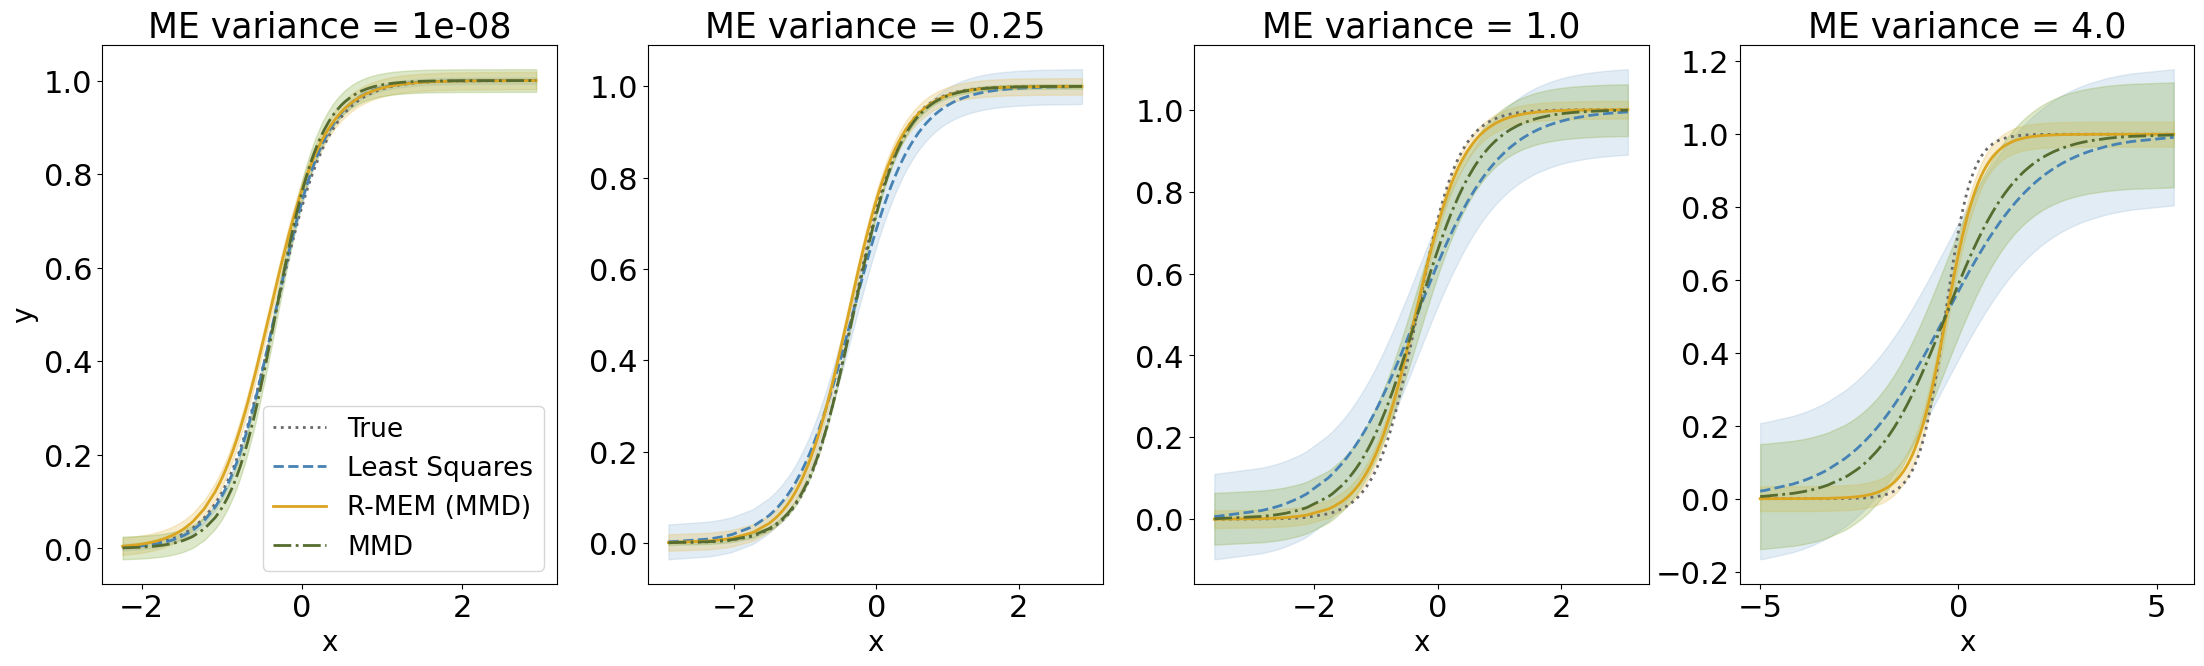

In [23]:
import matplotlib.pyplot as plt
num_methods = 3
num_realizations = 100
num_scales = len(scales_nu)
fig, ax_array = plt.subplots(1, num_scales, figsize=(27,7))
credible_interval = 0.90
n = 200
regs = np.zeros((num_realizations, num_methods, n))
lower_bounds = np.zeros((num_methods, n))
upper_bounds = np.zeros((num_methods, n))
std_error = np.zeros(num_methods)
means = np.zeros((num_methods, n))
for ax, j in zip(ax_array.flatten(), range(0, num_scales)):
    scale_nu = scales_nu[j]
    seed1 = 12
    seed2 = 112
    thetas_over_run = np.zeros((len(theta_star), num_methods, num_realizations))
    for r in range(num_realizations):
        seed1 += 1
        seed2 += 1
        boot_sample = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed1{seed1}_seed2{seed2}.txt')
        
        data, xis_star = sample_observed_data_berkson(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, seed1)#np.loadtxt(folder_path+f'data_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
        mean_boot_sample = boot_sample.mean(axis=0)
        mmd_est = np.loadtxt(folder_path_mmd+f'mmd_est_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed1{seed1}_seed2{seed2}.txt')
        initial_guess = np.random.uniform(low=-1, high=4, size=(2,)) #[0, 4]  # Initial parameter guess
        ls_estimator, _ = curve_fit(nonlinear_model, data[:,0], data[:,1], p0=initial_guess)
        thetas_over_run[:, 0, r] = mean_boot_sample
        thetas_over_run[:, 1, r] = ls_estimator
        thetas_over_run[:, 2, r] = mmd_est

        
    # test data
    data, xis_star = sample_observed_data_berkson(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, 300)
    xis_star_sorted = np.sort(xis_star)
    Y_real = reg_func(theta_star, xis_star_sorted)
    means[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1), xis_star_sorted)
    residuals = np.array(Y_real) - means[0, :]
    std_error[0] = np.std(residuals, axis=0)
    lower_bounds[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1) - thetas_over_run[:,0,:].std(axis=1), xis_star_sorted)
    upper_bounds[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1) + thetas_over_run[:,0,:].std(axis=1), xis_star_sorted)

    means[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1), xis_star_sorted)
    residuals = np.array(Y_real) - means[1, :]
    std_error[1] = np.std(residuals, axis=0)
    lower_bounds[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1) - thetas_over_run[:,1,:].std(axis=1), xis_star_sorted)
    upper_bounds[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1) + thetas_over_run[:,1,:].std(axis=1), xis_star_sorted)
    
    means[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1), xis_star_sorted)
    residuals = np.array(Y_real) - means[2, :]
    std_error[2] = np.std(residuals, axis=0)
    lower_bounds[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1) - thetas_over_run[:,2,:].std(axis=1), xis_star_sorted)
    upper_bounds[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1) + thetas_over_run[:,2,:].std(axis=1), xis_star_sorted)
    
    ax.plot(xis_star_sorted, Y_real, linestyle='dotted', label='True', color='dimgrey', lw=2)
    
    ax.plot(xis_star_sorted, means[1,:], linestyle='dashed', label='Least Squares', color='#4682B4', lw=2)
    #ax.fill_between(xis_star_sorted, lower_bounds[2, :], upper_bounds[2, :], color=lighten_color('#4682B4'), alpha=0.3)
    ax.fill_between(xis_star_sorted, means[1, :] - std_error[1], means[1, :] + std_error[1], color=lighten_color('#4682B4'), alpha=0.3)
    
    ax.plot(xis_star_sorted, means[0, :], linestyle='solid', label='R-MEM (MMD)', color='goldenrod',lw=2)
    #ax.fill_between(xis_star_sorted, lower_bounds[0, :], upper_bounds[0, :], color=lighten_color('goldenrod', 0.7), alpha=0.3)
    ax.fill_between(xis_star_sorted, means[0, :] - std_error[0], means[0, :] + std_error[0], color=lighten_color('goldenrod', 0.7), alpha=0.3)
    
    ax.plot(xis_star_sorted, means[2, :], linestyle='dashdot', label='MMD', color='#556B2F',lw=2)
    ax.fill_between(xis_star_sorted, means[2, :] - std_error[2], means[2, :] + std_error[2], color=lighten_color('#556B2F', 0.7), alpha=0.3)

    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    ax.patch.set_facecolor('white')
    if j == 0:
        ax.set_title(f'ME variance = 1e-08', fontsize=25)
    elif j == 1 or j == 3:
        ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)
    elif j == 2:
        ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)

    ax.set_xlabel('x',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=22)
    if j == 0:
        ax.legend(fontsize=19)
        ax.set_ylabel('y',fontsize=20)